In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.style.use('dark_background')
# plt.style.use('default')

In [2]:
import quflow as qf

# Generate random vorticity and plot it

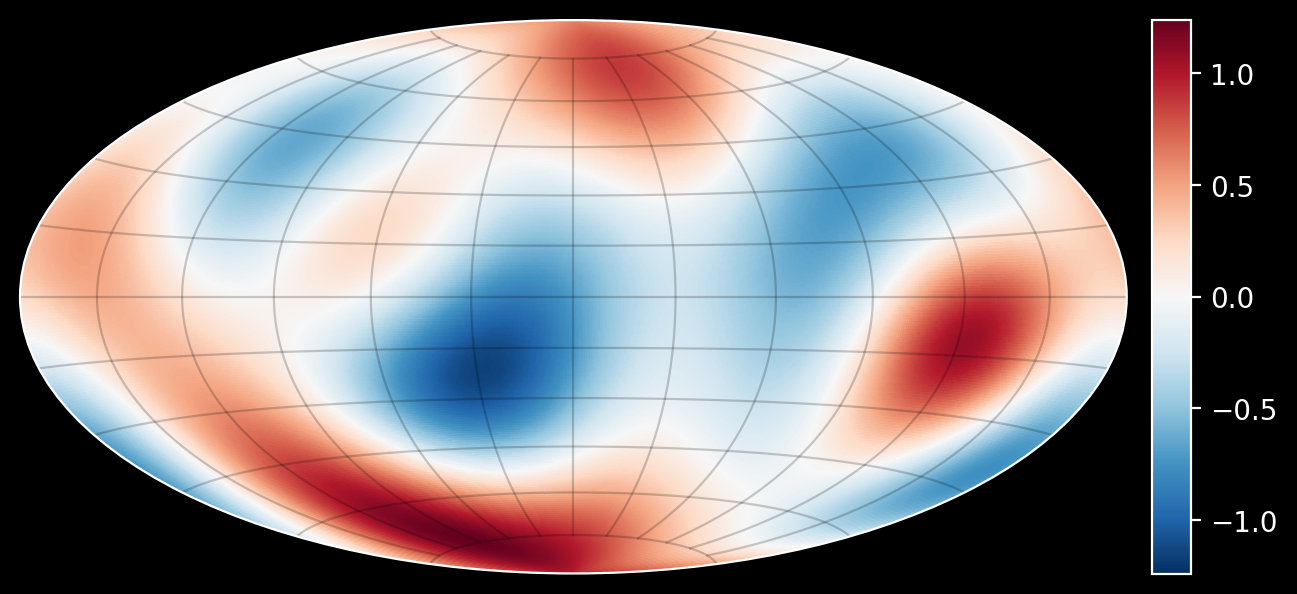

In [3]:
lmax = 5  # How many spherical harmonics (SH) coefficients to include
np.random.seed(42)  # For reproducability
omega0 = 0.1*np.random.randn(lmax**2)  # Array with SH coefficients
omega0[0] = 0.0  # Set vanishing total circulation
# omega0[1:4] = 0.0  # Set vanishing total angular momentum
qf.plot2(omega0, N=256, colorbar=True)  # Plot command

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are
$$\dot\omega = \{\psi,\omega\} $$
where $\omega$ is the vorticity function and $\psi$ is the stream function (related to $\omega$ via Poisson's equation). The quantized Euler equations are similar
$$\dot W = [P,W] $$
but here the vorticity function is replaced by the vorticity matrix $W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.


## Create initial conditions

In [4]:
N = 256  # Size of matrices
W0 = qf.shr2mat(omega0, N=N)  # Convert SH coefficients to matrix
P0 = qf.solve_poisson(W0)
print("  L2 norm: {}\nLinf norm: {}".format(qf.geometry.norm_L2(W0), qf.geometry.norm_Linf(W0)))

  L2 norm: 0.4730908694711157
Linf norm: 1.2144291424027773


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Setup simulation parameters

In [5]:
# Setup simulation

filename = "basic_sim_N_{}.hdf5".format(str(N))
simtime = 15.0 # in second
inner_time = 0.3 # in seconds
stepsize = 1.0 #qf.estimate_stepsize(W0, P0, safety_factor=0.1)

# Define logger functions
def energy(W):
    P = qf.laplacian.gpu.solve_poisson(W)
    return -qf.geometry.inner_L2(W, P)

def enstrophy(W):
    # return np.linalg.norm(W, ord='fro')
    return qf.geometry.inner_L2(W, W)

# Print summary of simulation settings
print("The non-dimensional stepsize is {:.3e}.".format(stepsize))
# print("Invariant stepsize is {}".format(np.sqrt(energy(W0))/enstrophy(W0)))
dt = qf.qtime2seconds(stepsize, N)
print("The physical time step is {:.3e} seconds.".format(dt))
print("In total {} steps, with {} steps per output, and thus {} output steps.".format(round(simtime/dt), round(inner_time/dt), round(simtime/inner_time)))

The non-dimensional stepsize is 1.000e+00.
The physical time step is 7.813e-03 seconds.
In total 1920 steps, with 38 steps per output, and thus 50 output steps.


## Run simulation

In [11]:
# Callback data object
W = W0.copy()
mysim = qf.QuSimulation(filename, overwrite=True, state=W, 
                        loggers={'energy':energy, 'enstrophy':enstrophy})

# Run simulation using the `solve` interface 
# and with `mysim` as a callback.
qf.solve(W,
         stepsize=stepsize, 
         simtime=simtime, 
         inner_time=inner_time, 
         callback=mysim, 
         integrator=qf.isomp,
         hamiltonian=qf.solve_poisson,
         verbatim=False
         )


100%|██████████| 1920/1920 [00:21<00:00, 89.25 steps/s]


In [6]:
# Alternatively, all the 'solve' arguments can be stored in the QuSimulation
# object. This is VERY convenient when moving a simulation from one computer
# to another.

mysim = qf.QuSimulation(filename, overwrite=True, state=W0,
                        loggers={'energy':energy, 'enstrophy':enstrophy})
mysim['stepsize'] = stepsize
mysim['simtime'] = simtime
mysim['inner_time'] = inner_time
mysim['integrator'] = qf.isomp
mysim['hamiltonian'] = qf.solve_poisson

# Run simulation directly from QuSimulation object
qf.solve(mysim)

100%|██████████| 640/640 [00:06<00:00, 94.13 steps/s]


In [22]:
a = (1,2,3,4)
a[1:]

(2, 3, 4)

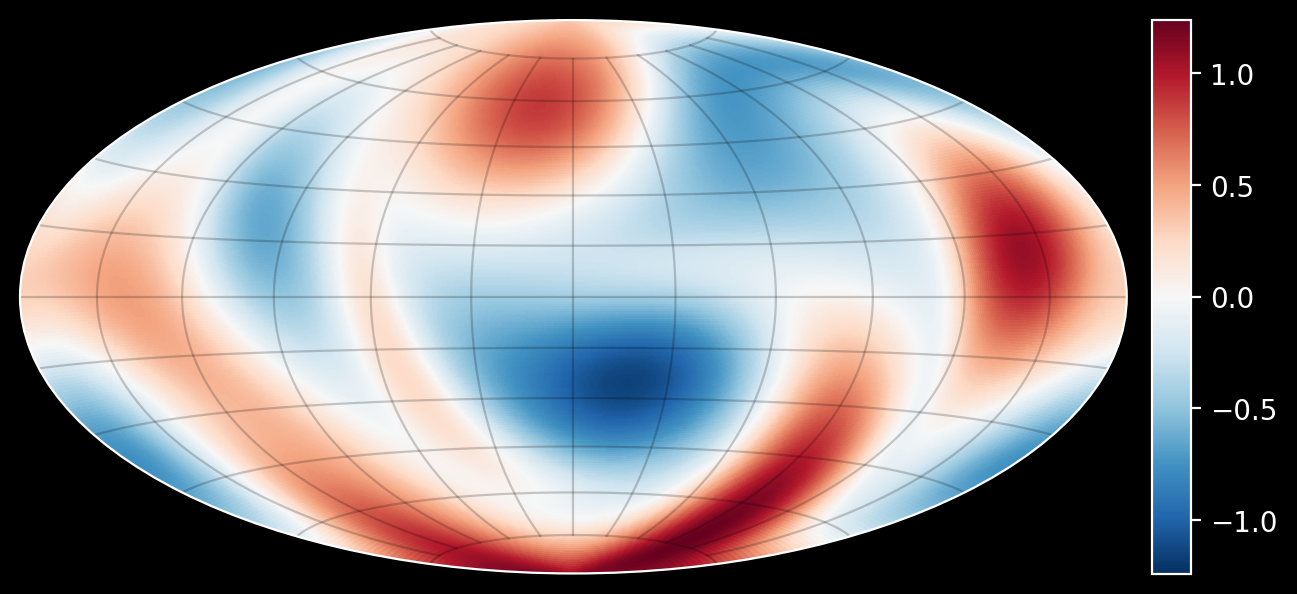

In [7]:
# Plot last state
qf.plot2(mysim['fun',-1], colorbar=True)

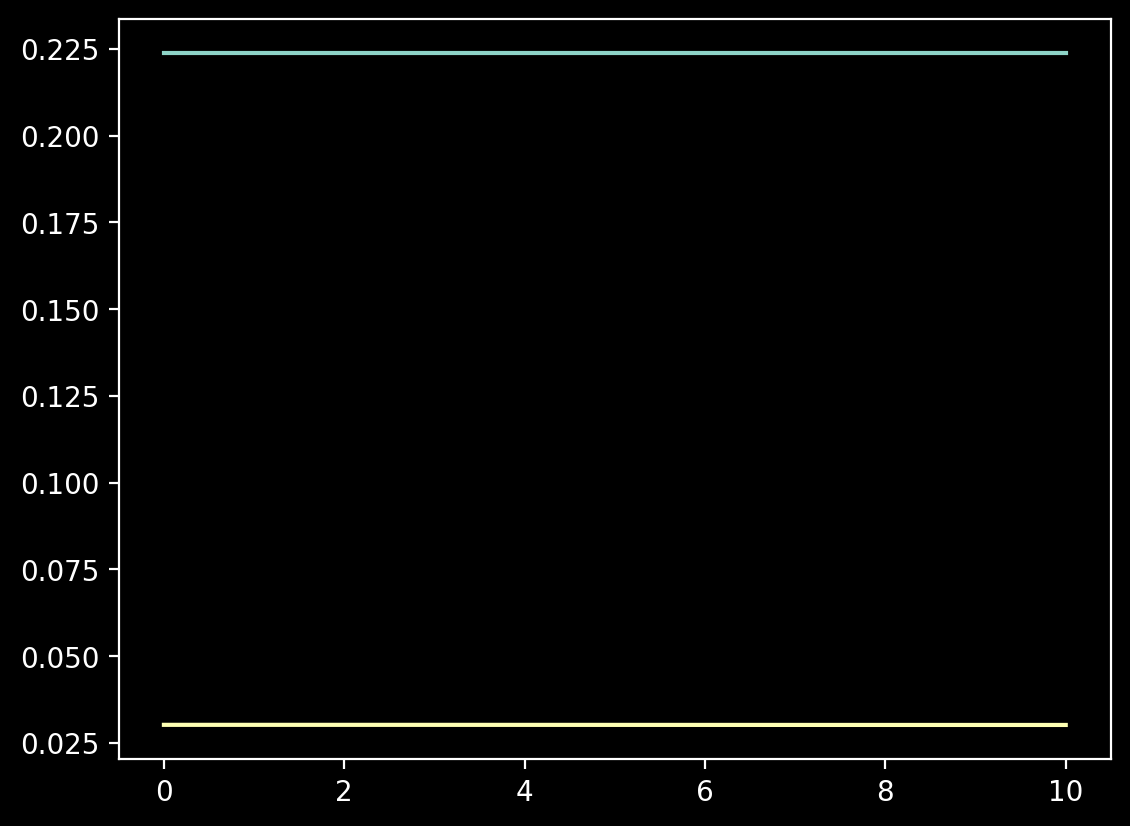

In [12]:
# Plot energy and enstrophy
plt.plot(mysim['time'],mysim['enstrophy'])
plt.plot(mysim['time'],mysim['energy'])

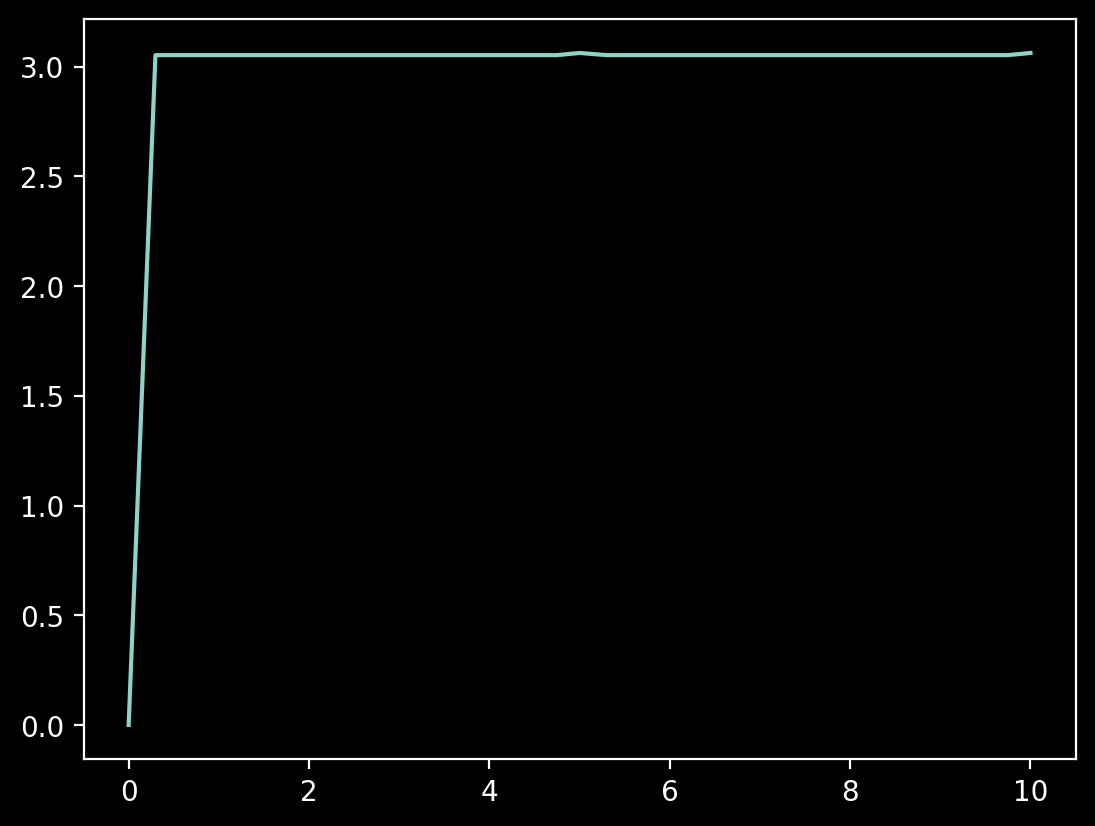

In [11]:
# Plot some integrator statistics
plt.plot(mysim['time'], mysim['iterations'])

## Run longer

In [10]:
# Just load the sim object and continue
mysim = qf.QuSimulation(filename)
qf.solve(mysim)

100%|██████████| 640/640 [00:06<00:00, 97.09 steps/s] 


## Animate the results

In [13]:
anim = qf.create_animation2(filename.replace(".hdf5",".mp4"), mysim['fun'])
anim

100%|██████████| 35/35 [00:01<00:00, 19.23 frames/s]


## Simulation with multiple components

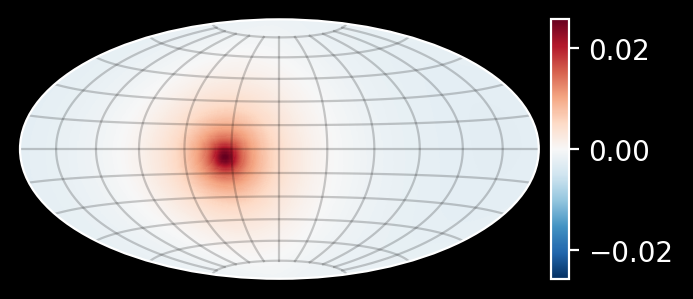

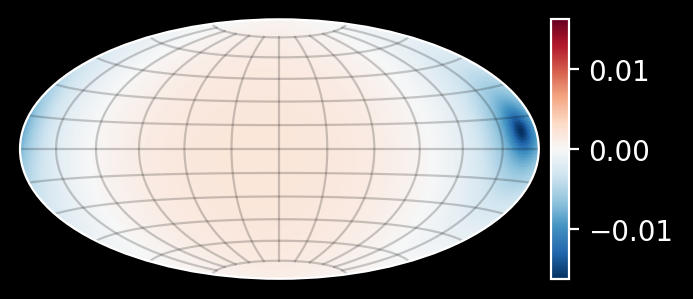

In [8]:
Theta1 = qf.dynamics.blob(N=N, pos=np.random.randn(3), sigma=3)
Theta2 = -qf.dynamics.blob(N=N, pos=np.random.randn(3), sigma=5)

with plt.rc_context({'figure.figsize':(3,3)}):
    qf.plot2(Theta1, colorbar=True)
    qf.plot2(Theta2, colorbar=True)

In [9]:
# Setup a simulation with 3 components, the first one as before, and the others some transported blobs

def multicomponent_hamiltonian(state):
    W = state[0]
    Theta1 = state[1]
    Theta2 = state[2]
    P = qf.solve_poisson(W)
    # If only one field is returned by the Hamiltonian (as here),
    # the isomp integrator interprets that as if the other fields
    # should just be transported.
    return P

state0 = np.array((W0, Theta1, Theta2))
filename_multi = "multicomponent_N_{}.hdf5".format(N)

# Define simulation object
sim_multi = qf.QuSimulation(filename_multi, overwrite=True, state=state0)

# Set `solve` arguments
sim_multi['stepsize'] = stepsize
sim_multi['simtime'] = simtime
sim_multi['inner_time'] = inner_time
sim_multi['integrator'] = qf.isomp
sim_multi['hamiltonian'] = multicomponent_hamiltonian

# Run simulation
qf.solve(sim_multi)


100%|██████████| 1920/1920 [00:59<00:00, 32.13 steps/s]


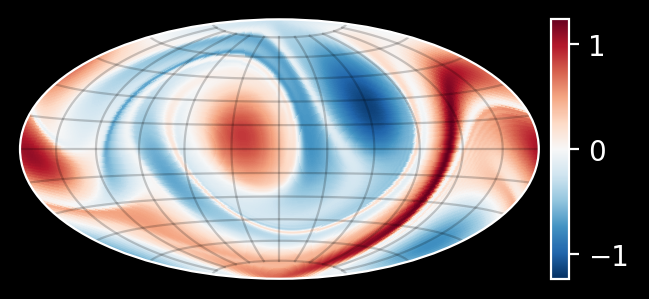

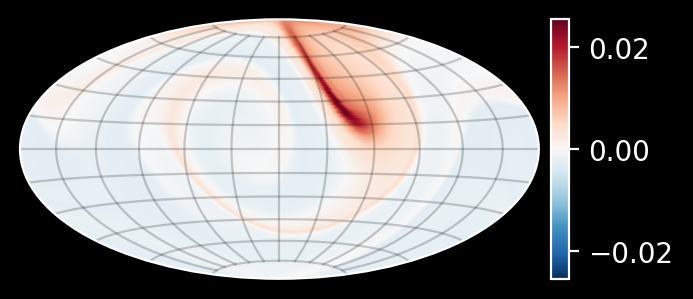

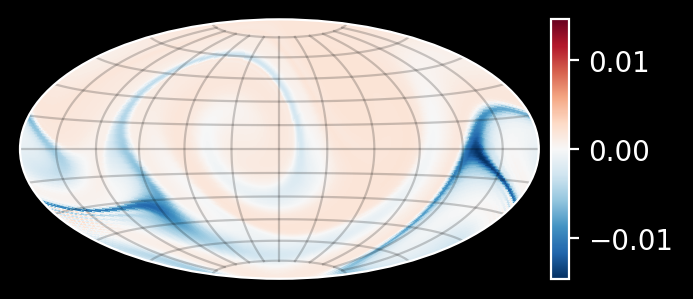

In [12]:
with plt.rc_context({'figure.figsize':(3,3)}):
    for k in range(3):
        qf.plot2(sim_multi['fun',-1,k], colorbar=True)

In [14]:
anim = qf.create_animation2(filename_multi.replace(".hdf5","_Theta2.mp4"), sim_multi['fun',:,2])
anim

100%|██████████| 52/52 [00:03<00:00, 17.10 frames/s]


## More advanced multicomponent: MHD

The MHD-equations are
$$
    \dot W = \frac{1}{\hbar}[P, W] {+\color{green}[B, \Theta]}
$$
$$
    \dot \Theta = \frac{1}{\hbar}[P, \Theta] \phantom{+ [M,\Theta]}
$$
Consider the multicomponent state $V=[W,\Theta]$. The Hamiltonian, returning $P$ and $B$, is then:

In [3]:
def mhd_ham(V):
    W = V[0]
    Theta = V[1]
    P = qf.solve_poisson(W)
    B = qf.laplacian.laplace(Theta)
    return P, B

We can now setup an MHD simulation, where the $W$ and $\Theta$ are blobs:

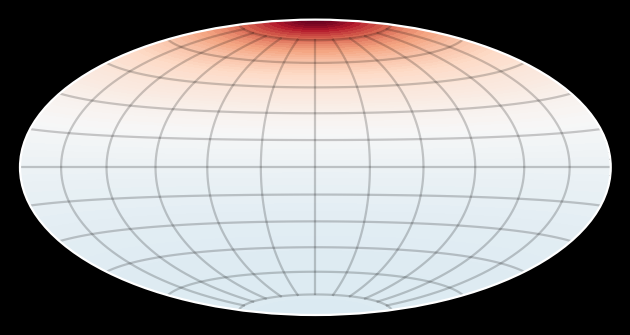

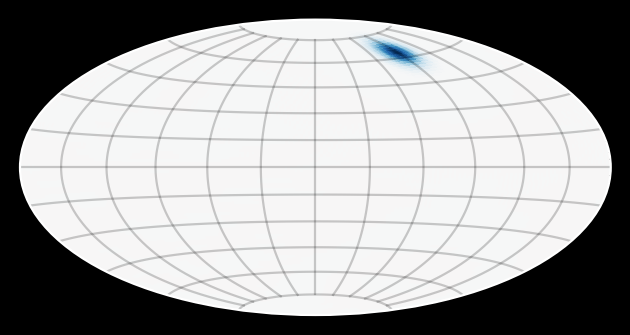

In [41]:
N = 128
W = qf.dynamics.blob(N=N, pos=np.array([0,0,-1]), sigma=5)
Theta = -qf.dynamics.blob(N=N, pos=np.array([0,1,-2]))
V0 = np.array([W,Theta])

with plt.rc_context({'figure.figsize':(3,3)}):
    qf.plot2(W)
    qf.plot2(Theta)

In [38]:
# MHD simulation 

filename_mhd = "mhd_N_{}.hdf5".format(N)

# Define simulation object
sim_mhd = qf.QuSimulation(filename_mhd, overwrite=True, state=V0)

# Set `solve` arguments
sim_mhd['stepsize'] = 0.2
sim_mhd['simtime'] = 25.0
sim_mhd['inner_time'] = 0.1
sim_mhd['integrator'] = qf.integrators.magmp
sim_mhd['hamiltonian'] = mhd_ham

# Run simulation
qf.solve(sim_mhd)

100%|██████████| 8000/8000 [01:33<00:00, 85.47 steps/s]


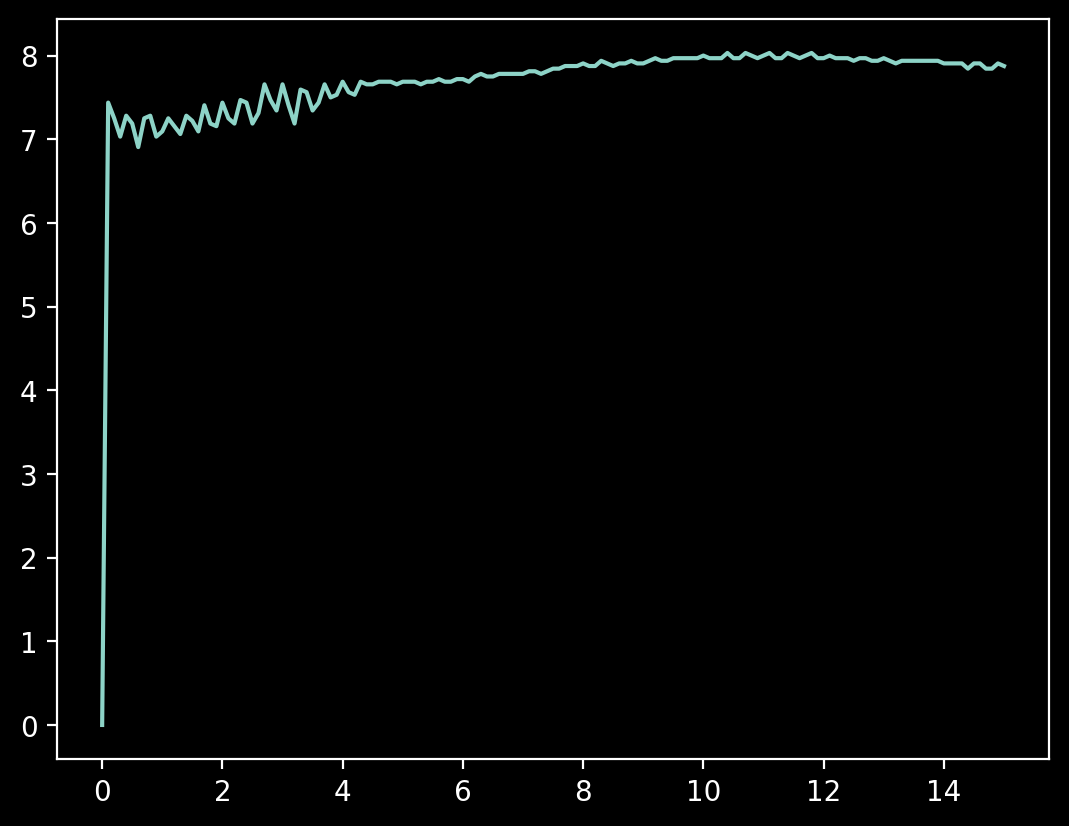

In [34]:
filename_mhd = "mhd_N_{}.hdf5".format(N)

sim_mhd = qf.QuSimulation(filename_mhd)
plt.plot(sim_mhd['time'],sim_mhd['iterations'])

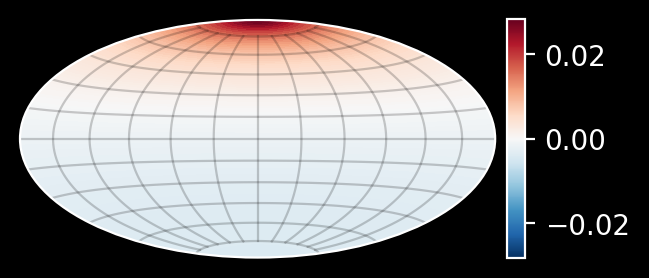

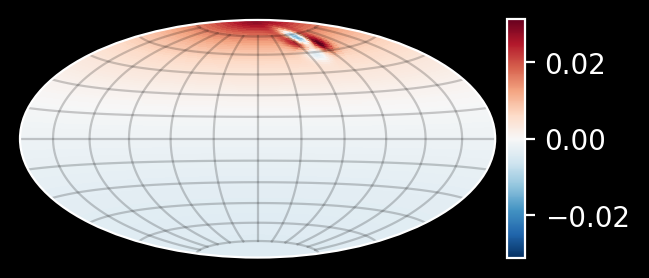

In [42]:
with plt.rc_context({'figure.figsize':(3,3)}):
    qf.plot2(sim_mhd['fun',0,0],colorbar=True)
    qf.plot2(sim_mhd['fun',-1,0],colorbar=True)

In [40]:
anim = qf.create_animation2(filename_mhd.replace(".hdf5","_W.mp4"), sim_mhd['fun',:,0])
anim

100%|██████████| 251/251 [00:04<00:00, 56.53 frames/s]


## Compute canonical decomposition

In [25]:
[Ws,Wr] = qf.analysis.scale_decomposition(W)

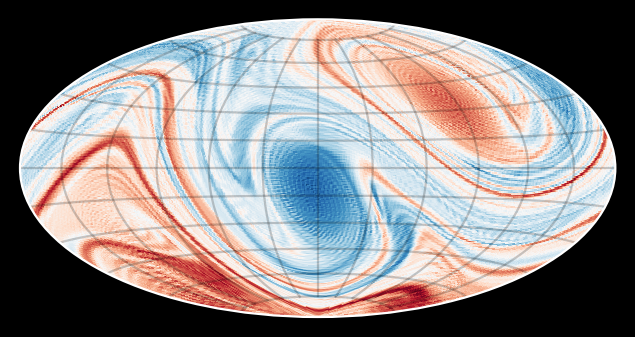

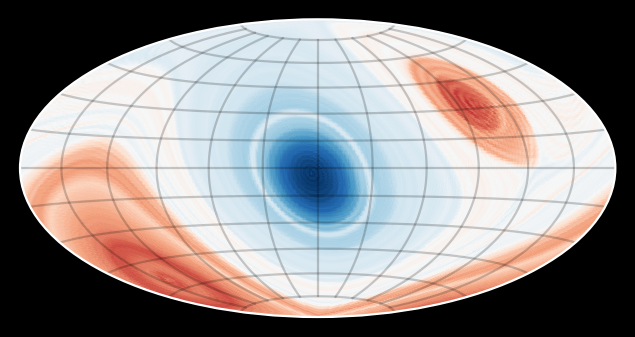

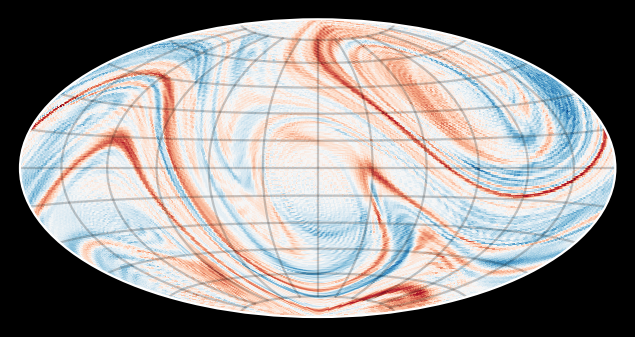

In [26]:
with plt.rc_context({'figure.figsize':(3,3)}):
    for Ww in [W, Ws, Wr]:
        qf.plot2(Ww)

## Run on cluster (OLD)

The code below should no longer be used. Instead, just copy the QuSimulation hdf5 file and start manually on the cluster.

In [8]:
import quflow.cluster as cluster

In [14]:
epsilon = 0.01

def forcing(P, W):
    Ws, Wr = qf.scale_decomposition(W, P)
    return -epsilon*Wr

force_code = In[len(In)-1]

In [15]:
# Start longer simulation on cluster
cluster.solve(filename, qstepsize=qstepsize, time=time, inner_time=inner_time, 
              method_kwargs={'forcing':forcing}, prerun=force_code,
              animate=True, simulate=True,
              upload=True, submit=True)

/Users/moklas/Documents/Coding/quflow/quflow/cluster.py:438: UserWarning: Could not establish jobstatus.
  warnings.warn("Could not establish jobstatus.")


#### CREATING RUN FILES ####
########### DONE ###########

#### UPLOADING FILES TO SERVER ####
> rsync -auv my_sim_N_128.hdf5 my_sim_N_128_run.py my_sim_N_128_submit.sh my_sim_N_128_args.pickle my_sim_N_128_cluster.pickle vera2:simulations/my_sim_N_128
building file list ... done
created directory simulations/my_sim_N_128
my_sim_N_128.hdf5
my_sim_N_128_args.pickle
my_sim_N_128_cluster.pickle
my_sim_N_128_run.py
my_sim_N_128_submit.sh

sent 7302271 bytes  received 130 bytes  14604802.00 bytes/sec
total size is 7300991  speedup is 1.00
> rsync -auv --exclude __pycache__ --exclude .DS_Store /Users/moklas/Documents/Coding/quflow/quflow vera2:simulations/my_sim_N_128
building file list ... done
quflow/
quflow/__init__.py
quflow/cluster.py
quflow/dynamics.py
quflow/graphics.py
quflow/io.py
quflow/quantization.py
quflow/splittingflow.py
quflow/transforms.py
quflow/utils.py
quflow/laplacian/
quflow/laplacian/__init__.py
quflow/laplacian/direct.py
quflow/laplacian/sparse.py
quflow/laplacian/tri

In [28]:
cluster.jobstatus()

JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [27]:
# Check status
cluster.status(filename)

 Animation: 100%|##########| 79/79 [00:10<00:00,  7.24 frames/s] (jobstatus: not running)


In [29]:
cluster.retrieve(filename, onlysim=True)

> rsync -auv vera2:'simulations/my_sim_N_128/my_sim_N_128.mp4' .
receiving file list ... done
my_sim_N_128.mp4

sent 8744 bytes  received 1227898 bytes  824428.00 bytes/sec
total size is 1227463  speedup is 0.99
